# 1 Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [ ]:
!python -m pip install -U gensim
!python -m pip install -U pattern

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pattern.en import lemma

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [2]:
col = 2                             # Define which columns are used for topic modelling.
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents 
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  30              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
eta = 'auto'                      #A-priori belief on word probability,
random_state  = 12345     #Either a randomState object or a seed to generate one. Useful for reproducibility.

## 1.3 Corpus Reading 

In [3]:
df = pd.read_csv("NewChunkAll-STRIP-ASCII.csv", header = None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8
0,1,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Examination of Witnesses,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,SEPTEMBER,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,MS BARBARA CASSANI,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Q Chairman Good morning Ms Cassani I should ve...,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Ms Cassani Thank you very much Thank you very ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,a good time for the country to get behind an ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,p repeating not just to you but to myself and ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,the venues and how we will be approaching the ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23147 entries, 0 to 23146
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       23147 non-null  int64 
 1   1       23147 non-null  object
 2   2       23147 non-null  object
 3   3       383 non-null    object
 4   4       193 non-null    object
 5   5       7 non-null      object
 6   6       7 non-null      object
 7   7       1 non-null      object
 8   8       1 non-null      object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


## 1.4 Data Processing

Word number: 23147


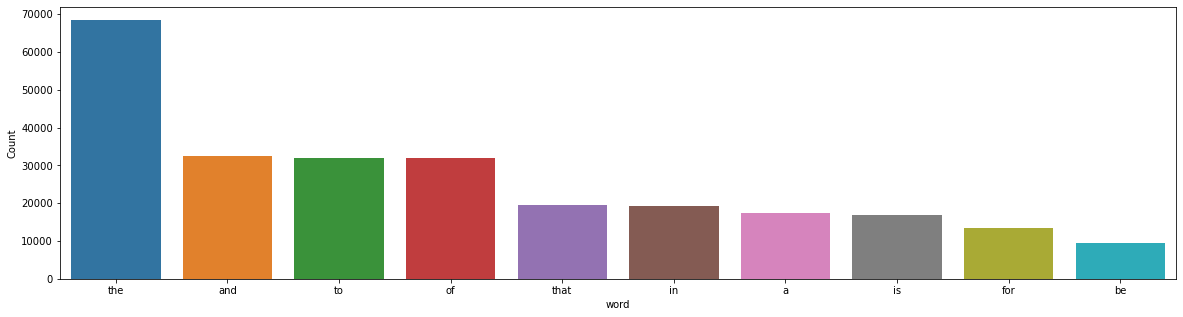

In [9]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Word number: %d'% (len(df[col])))
freq_words(df[2],10) 

<ipython-input-10-03fde7e31d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = df[col][i].lower()
<ipython-input-10-03fde7e31d6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = tokenizer.tokenize(df[col][i])


Tokens number: 19326


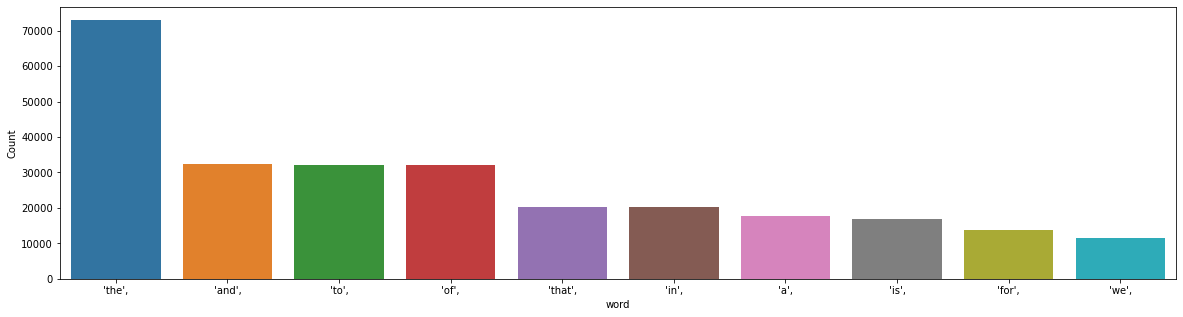

In [10]:
#Tokenize the corpus 
tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(df)):
    df[col][i] = df[col][i].lower()
    df[col][i] = tokenizer.tokenize(df[col][i])

print('Tokens number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing number: 19133


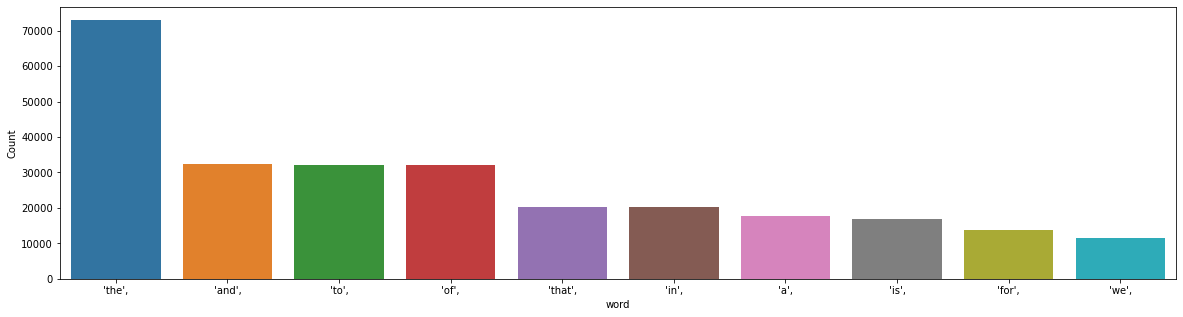

In [11]:
#Remove the number
df[col] = [ [token for token in doc if not token.isnumeric()] for doc in df[col]]

print('Tokens number after removing number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing stop words: 18997


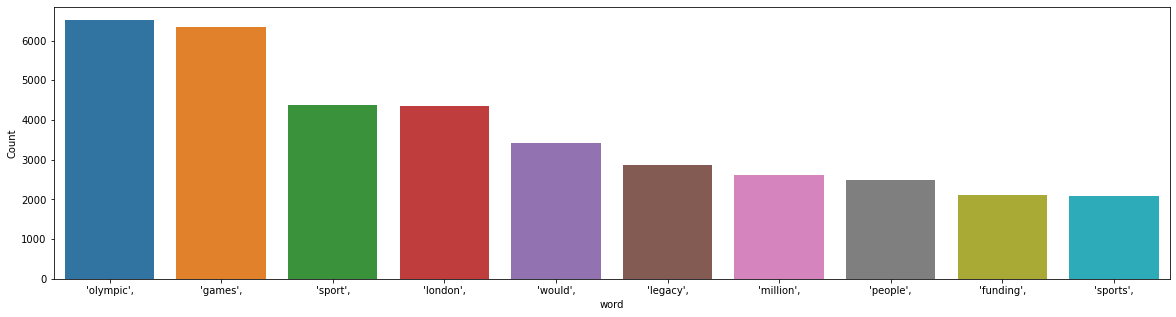

In [12]:
#Reomve stop words
stop_words = stopwords.words('english')
df[col] = [ [token for token in doc if not token in stop_words] for doc in df[col] ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing short words: 18261


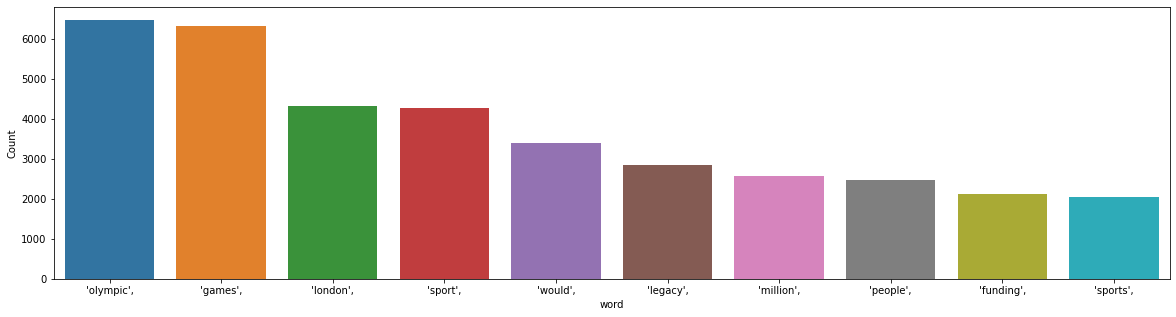

In [13]:
#Remove short words (length< min_len)
df[col] = [ [token for token in doc if not len(token) < min_len] for doc in df[col] ]
print('Tokens number after removing short words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after lemmation: 13865


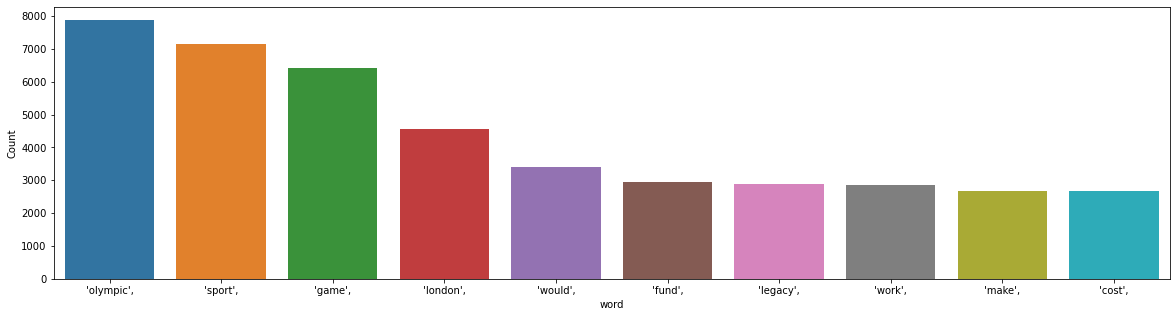

In [15]:
# Corpus Lemmation
df[col] = [ [lemma(token) for token in doc ] for doc in df[col] ]

print('Tokens number after lemmation: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after adding bigram: 14790


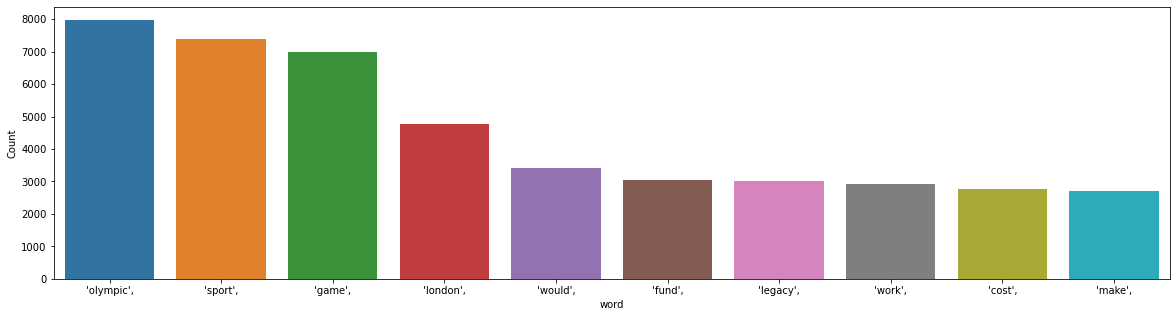

In [16]:
# Make bigram
bigrams_phases = Phrases(df[col], min_count = 10)
for i in range(len(df[col])):
    for token in bigrams_phases[df[col][i]]:
        if '_' in token:
            df[col][i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

## 1.5 The LDA Model Building

In [17]:
# Build a dictionary
LOdict = Dictionary(df[col])

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 14790


In [18]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 8878


In [19]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in df[col]]

In [23]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [27]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)

In [28]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = df[col], dictionary = LOdict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Cohernece Score c_v: ', coherence_lda, ' when topics number: ', num_topics)

Cohernece Score c_v:  0.5481137898396572  when topics number:  30


## 1.6 Corpus Classification

In [29]:
#Make a classifier to classify each paragraph of London Olympics Corpus
classifer = list()
for d in df[col]:
    bow = LOdict.doc2bow(d)
    belong = LOldamodel.get_document_topics(bow,per_word_topics=False)
    classifer.append(belong)
    
classiferdf = pd.DataFrame(classifer)

In [30]:
#Transform London Olympics Corpus to Dataframe
LOdf = pd.DataFrame(df[col])

In [32]:
#Make the Dataframe of the biggest distribution of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(LOcorpus)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
    #print(i[bz][0],i,listj,listj.index(max(listj)))
    #print(i[bz][0])
    MTopics.append(bz)

MTopics = pd.DataFrame(MTopics)

In [33]:
#Integrate dataframe of orgrinal corpus, classifier, and the biggest distribution of each paragraph
classifer_document = pd.concat([LOdf,MTopics,classiferdf],axis=1)
classifer_document

,2,0,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,"[examination, witness, examination_witness]",6,"(0, 0.03144736)","(1, 0.05030356)","(2, 0.03144736)","(3, 0.03144736)","(4, 0.03144736)","(5, 0.03144736)","(6, 0.051335342)","(7, 0.03144736)",...,"(20, 0.03144736)","(21, 0.03144736)","(22, 0.03144736)","(23, 0.03144736)","(24, 0.03144736)","(25, 0.03144736)","(26, 0.03144736)","(27, 0.03144736)","(28, 0.03144736)","(29, 0.03144736)"
1,[september],11,"(0, 0.03267994)","(1, 0.03267994)","(2, 0.03267994)","(3, 0.03267994)","(4, 0.03267994)","(5, 0.03267994)","(6, 0.03267994)","(7, 0.03267994)",...,"(20, 0.03267994)","(21, 0.03267994)","(22, 0.03267994)","(23, 0.03267994)","(24, 0.03267994)","(25, 0.03267994)","(26, 0.03267994)","(27, 0.03267994)","(28, 0.03267994)","(29, 0.03267994)"
2,"[barbara, cassani]",0,"(0, 0.03333333)","(1, 0.03333333)","(2, 0.03333333)","(3, 0.03333333)","(4, 0.03333333)","(5, 0.03333333)","(6, 0.03333333)","(7, 0.03333333)",...,"(20, 0.03333333)","(21, 0.03333333)","(22, 0.03333333)","(23, 0.03333333)","(24, 0.03333333)","(25, 0.03333333)","(26, 0.03333333)","(27, 0.03333333)","(28, 0.03333333)","(29, 0.03333333)"
3,"[chairman, good, morn, cassani, much, like, we...",15,"(0, 0.02892671)","(1, 0.016470017)","(2, 0.025957586)","(3, 0.016131362)","(4, 0.016122583)","(5, 0.016051013)","(6, 0.026361212)","(7, 0.01741114)",...,"(20, 0.027490297)","(21, 0.06049833)","(22, 0.01643801)","(23, 0.08772428)","(24, 0.016028522)","(25, 0.0514411)","(26, 0.045061406)","(27, 0.016895404)","(28, 0.030272424)","(29, 0.03144338)"
4,"[cassani, thank, much, thank, much, give, oppo...",18,"(0, 0.052923836)","(1, 0.039239354)","(2, 0.019088844)","(3, 0.010316154)","(4, 0.011147156)","(5, 0.023731511)","(6, 0.024956582)","(7, 0.016358465)",...,"(26, 0.0121401865)","(27, 0.032023206)","(28, 0.015345826)","(29, 0.05630026)",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,"[advertise, strong, likelihood, visit, within,...",13,"(0, 0.023812175)","(1, 0.036658715)","(2, 0.03049826)","(3, 0.038153674)","(4, 0.024416285)","(5, 0.023812171)","(6, 0.024103114)","(7, 0.023815246)",...,"(20, 0.023812171)","(21, 0.023812171)","(22, 0.023812171)","(23, 0.02429653)","(24, 0.046861704)","(25, 0.038072348)","(26, 0.03030961)","(27, 0.038083035)","(28, 0.028121011)","(29, 0.07894541)"
23143,"[jonathan, stephen, permanent, secretary, jona...",19,"(0, 0.03086448)","(1, 0.03086448)","(2, 0.03086448)","(3, 0.03086448)","(4, 0.03086448)","(5, 0.03086448)","(6, 0.03086448)","(7, 0.03086448)",...,"(20, 0.03086448)","(21, 0.03086448)","(22, 0.03086448)","(23, 0.03086448)","(24, 0.03086448)","(25, 0.03086448)","(26, 0.03086448)","(27, 0.03086448)","(28, 0.035281345)","(29, 0.03086448)"
23144,[december],12,"(0, 0.032679778)","(1, 0.032679778)","(2, 0.032679778)","(3, 0.032679778)","(4, 0.032679778)","(5, 0.032679778)","(6, 0.032679778)","(7, 0.032679778)",...,"(20, 0.032679778)","(21, 0.032679778)","(22, 0.032679778)","(23, 0.032679778)","(24, 0.032679778)","(25, 0.032679778)","(26, 0.032679778)","(27, 0.032679778)","(28, 0.032679778)","(29, 0.032679778)"
23145,[pefc],0,"(0, 0.03333333)","(1, 0.03333333)","(2, 0.03333333)","(3, 0.03333333)","(4, 0.03333333)","(5, 0.03333333)","(6, 0.03333333)","(7, 0.03333333)",...,"(20, 0.03333333)","(21, 0.03333333)","(22, 0.03333333)","(23, 0.03333333)","(24, 0.03333333)","(25, 0.03333333)","(26, 0.03333333)","(27, 0.03333333)","(28, 0.03333333)","(29, 0.03333333)"


In [35]:
#Output final dataframe
classifer_document.columns = ["Corpus","Biggest distribution topic","T0%","T1%","T2%","T3%","T4%","T5%","T6%","T7%","T8%","T9%","T10%",
                             "T11%","T12%","T13%","T14%","T15%","T16%","T17%","T18%","T19%","T20%",
                             "T21%","T22%","T23%","T24%","T25%","T26%","T27%","T28%","T29%",]

classifer_document.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/classifer.csv')

In [36]:
#Output topics distribution of whole corpus
topic_distribution = pd.DataFrame(LOldamodel.print_topics(num_topics = num_topics))
topic_distribution.columns = ["Topic index","Topic Distribution"]
topic_distribution
topic_distribution.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/topic distribution.csv',index=False)